In [185]:
import requests
import json
from pprint import pprint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# The df that we are going to pull is nfl score data from espn

In [3]:
# The question we are looking to answer is if we can predict the total points 
# that will be scored during this weekend's superbowl game

In [4]:
# Step 1
# We began by collecting raw NFL game data from ESPN’s public API 
# without filtering variables, so we could first understand what 
# information was available

In [5]:
response = requests.get("https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard")
print(response.status_code)

raw_data = response.json()

200


In [6]:
pprint(response.json())

{'events': [{'competitions': [{'attendance': 0,
                               'broadcast': 'NBC/Peacock',
                               'broadcasts': [{'market': 'national',
                                               'names': ['NBC', 'Peacock']}],
                               'competitors': [{'homeAway': 'home',
                                                'id': '17',
                                                'leaders': [{'abbreviation': 'PYDS',
                                                             'displayName': 'Passing '
                                                                            'Leader',
                                                             'leaders': [{'athlete': {'active': True,
                                                                                      'displayName': 'Drake '
                                                                                                     'Maye',
                                       

In [7]:
def extract_game_fields(event):
    comps = event.get("competitions", [])
    if not comps:
        return None

    comp = comps[0]

    competitors = comp.get("competitors", [])
    if not competitors:
        return None

    home = next((t for t in competitors if t.get("homeAway") == "home"), None)
    away = next((t for t in competitors if t.get("homeAway") == "away"), None)
    if home is None or away is None:
        return None

    venue = comp.get("venue", {}) or {}
    address = venue.get("address", {}) or {}     # <-- NEW
    weather = event.get("weather", {}) or {}

    def safe_int(x):
        try:
            return int(x)
        except (TypeError, ValueError):
            return 0

    home_score = safe_int(home.get("score"))
    away_score = safe_int(away.get("score"))

    season = event.get("season", {}) or {}
    week = event.get("week", {}) or {}
    status = event.get("status", {}).get("type", {}) or {}

    return {
        "game_id": event.get("id"),
        "season": season.get("year"),
        "season_type": season.get("type"),
        "week": week.get("number"),
        "date": event.get("date"),

        "home_team": home.get("team", {}).get("displayName"),
        "away_team": away.get("team", {}).get("displayName"),

        "home_score": home_score,
        "away_score": away_score,
        "total_points": home_score + away_score,

        "venue_id": venue.get("id"),
        "venue_name": venue.get("fullName"),
        "venue_city": address.get("city"),
        "venue_state": address.get("state"),
        "venue_country": address.get("country"),

        "indoor": venue.get("indoor"),
        "temperature": weather.get("temperature"),
        "weather": weather.get("displayValue"),
        "status": status.get("name"),
    }

In [8]:
# We isolated the most relevant columns from our API and pulled a random game to
# assess the return

In [9]:
import random

events = raw_data["events"]
sample_events = random.sample(events, min(5, len(events)))

sample_rows = [extract_game_fields(e) for e in sample_events]

sample_raw_nfl_game_data_df = pd.DataFrame(sample_rows)
sample_raw_nfl_game_data_df

,game_id,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_id,venue_name,venue_city,venue_state,venue_country,indoor,temperature,weather,status
0,401772988,2025,3,5,2026-02-08T23:30Z,New England Patriots,Seattle Seahawks,0,0,0,4738,Levi's Stadium,Santa Clara,CA,USA,False,65,Partly sunny,STATUS_SCHEDULED


In [10]:
# The return gave us relevent information, but the random game was for a future game
# hence the total score being 0, so we will have to isolate a date range to identify
# which games we want to look at

In [11]:
# Our goal is to predict the total score for the superbowl, so we only want games
# that are similar to the superbowl. Based on our research, the NFL significantly
# changed scoring rules in 1994, but we will clean that data later.

In [12]:
sample_raw_nfl_game_data_df["date"].dtype

dtype('O')

In [13]:
# We noticed that date is a string, so we are converting it into a real datetime object
# so we can filter by year

In [14]:
sample_raw_nfl_game_data_df["date"] = pd.to_datetime(
    sample_raw_nfl_game_data_df["date"],
    errors="coerce"
)

In [15]:
sample_raw_nfl_game_data_df["date"].dtype

datetime64[ns, UTC]

In [16]:
# Now we will pull data from 1994 until now to start creating a df

In [17]:
BASE_URL = "https://site.api.espn.com/apis/site/v2/sports/football/nfl/scoreboard"

def get_scoreboard(start_date, end_date):
    dates_param = start_date.strftime("%Y%m%d") + "-" + end_date.strftime("%Y%m%d")
    response = requests.get(BASE_URL, params={"dates": dates_param})
    response.raise_for_status()
    return response.json()

In [18]:
print(response.status_code)

200


In [19]:
import datetime as dt

start = dt.date(1994, 1, 1)
end = dt.date.today()

all_events = []

current = start
while current <= end:
    window_end = min(current + dt.timedelta(days=6), end)

    data = get_scoreboard(current, window_end)
    all_events.extend(data.get("events", []))

    current = window_end + dt.timedelta(days=1)

In [20]:
print("DONE. Total events:", len(all_events))

DONE. Total events: 10111


In [21]:
def extract_game_fields(event):
    comps = event.get("competitions", [])
    if not comps:
        return None

    comp = comps[0]

    competitors = comp.get("competitors", [])
    if not competitors:
        return None

    home = next((t for t in competitors if t.get("homeAway") == "home"), None)
    away = next((t for t in competitors if t.get("homeAway") == "away"), None)
    if home is None or away is None:
        return None

    venue = comp.get("venue", {}) or {}
    address = venue.get("address", {}) or {}   # <-- added
    weather = event.get("weather", {}) or {}

    def safe_int(x):
        try:
            return int(x)
        except (TypeError, ValueError):
            return 0

    home_score = safe_int(home.get("score"))
    away_score = safe_int(away.get("score"))

    season = event.get("season", {}) or {}
    week = event.get("week", {}) or {}
    status = event.get("status", {}).get("type", {}) or {}

    return {
        "game_id": event.get("id"),
        "season": season.get("year"),
        "season_type": season.get("type"),
        "week": week.get("number"),
        "date": event.get("date"),

        "home_team": home.get("team", {}).get("displayName"),
        "away_team": away.get("team", {}).get("displayName"),

        "home_score": home_score,
        "away_score": away_score,
        "total_points": home_score + away_score,

        "venue_id": venue.get("id"),
        "venue_name": venue.get("fullName"),
        "venue_city": address.get("city"),
        "venue_state": address.get("state"),
        "venue_country": address.get("country"),

        "indoor": venue.get("indoor"),
        "temperature": weather.get("temperature"),
        "weather": weather.get("displayValue"),

        "status": status.get("name"),
    }

In [22]:
rows = [extract_game_fields(e) for e in all_events]
rows = [r for r in rows if r is not None]  # drop weird/incomplete events

In [23]:
raw_nfl_game_data_df = pd.DataFrame(rows)
raw_nfl_game_data_df.head()

,game_id,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_id,venue_name,venue_city,venue_state,venue_country,indoor,temperature,weather,status
0,140102001,1993,2,NaN,1994-01-02T05:00Z,Atlanta Falcons,Phoenix Cardinals,10,27,37,None,None,None,None,None,None,NaN,None,STATUS_FINAL
1,140102008,1993,2,NaN,1994-01-02T05:00Z,Detroit Lions,Green Bay Packers,30,20,50,None,None,None,None,None,None,NaN,None,STATUS_FINAL
2,140102010,1993,2,NaN,1994-01-02T05:00Z,Houston Oilers,New York Jets,24,0,24,None,None,None,None,None,None,NaN,None,STATUS_FINAL
3,140102011,1993,2,NaN,1994-01-02T05:00Z,Indianapolis Colts,Buffalo Bills,10,30,40,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4,140102012,1993,2,NaN,1994-01-02T05:00Z,Kansas City Chiefs,Seattle Seahawks,34,24,58,None,None,None,None,None,None,NaN,None,STATUS_FINAL


In [24]:
raw_nfl_game_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10110 entries, 0 to 10109
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        10110 non-null  object 
 1   season         10110 non-null  int64  
 2   season_type    10110 non-null  int64  
 3   week           8816 non-null   float64
 4   date           10110 non-null  object 
 5   home_team      10110 non-null  object 
 6   away_team      10110 non-null  object 
 7   home_score     10110 non-null  int64  
 8   away_score     10110 non-null  int64  
 9   total_points   10110 non-null  int64  
 10  venue_id       6891 non-null   object 
 11  venue_name     6891 non-null   object 
 12  venue_city     6890 non-null   object 
 13  venue_state    6835 non-null   object 
 14  venue_country  6890 non-null   object 
 15  indoor         6891 non-null   object 
 16  temperature    1 non-null      float64
 17  weather        1 non-null      object 
 18  status

In [25]:
# We pulled data from the 1994 season until now and are assessing the kind of data
# available. Initially it looks like we have most of the games (10,109), but not all
# since it should be closer to 16,000 games (32 teams x ~17 games per season x 31 yrs)
# We also see that some data is strings, weather data is missing, and some location 
# data is missing. Now we will assess if theres a trend in the games with missing data

In [26]:
raw_nfl_game_data_df["season_type"].value_counts(dropna=False)

season_type
2    8168
1    1543
3     399
Name: count, dtype: int64

In [27]:
raw_nfl_game_data_df["status"].value_counts(dropna=False)

status
STATUS_FINAL        10106
STATUS_POSTPONED        3
STATUS_SCHEDULED        1
Name: count, dtype: int64

In [28]:
raw_nfl_game_data_df["indoor"].value_counts(dropna=False)

indoor
False    5040
None     3219
True     1851
Name: count, dtype: int64

In [29]:
# Season type shows preseason (1), regular season (2), and post season (3)
# The vast majority of games are final, which is good
# There is a lot of missing data on if the game is indoor or not
# We will now assess if the data becomes more reliable over time

In [30]:
raw_nfl_game_data_df.groupby("season")["indoor"].apply(lambda x: x.notna().mean())

season
1986    0.000000
1988    0.000000
1992    0.000000
1993    0.041667
1994    0.076596
1995    0.071713
1996    0.071713
1997    0.108000
1998    0.103586
1999    0.131274
2000    0.114198
2001    0.114551
2002    0.116766
2003    0.110778
2004    0.116766
2005    0.113772
2006    0.882883
2007    0.882883
2008    0.996997
2009    0.996997
2010    1.000000
2011    1.000000
2012    1.000000
2013    0.996997
2014    1.000000
2015    1.000000
2016    1.000000
2017    1.000000
2018    1.000000
2019    1.000000
2020    1.000000
2021    1.000000
2022    1.000000
2023    1.000000
2024    1.000000
2025    1.000000
Name: indoor, dtype: float64

In [31]:
# Based on this information indoor game information is vary unreliable until 2006
# when it is populated 88% of the time and after 2010 it is reliable

In [32]:
# Our analysis revealed that venue-level indoor/outdoor data is largely unavailable
# prior to the mid-2000s, with coverage increasing sharply around 2006 and reaching 
# full completeness by 2010. This indicates that indoor status is a modern feature in 
# the ESPN dataset and must be handled carefully when analyzing earlier seasons

In [33]:
raw_nfl_game_data_df.groupby("season")["total_points"].mean()

season
1986    24.000000
1988    28.000000
1992    51.000000
1993    42.750000
1994    37.642553
1995    40.701195
1996    38.597610
1997    38.340000
1998    39.788845
1999    39.019305
2000    38.108025
2001    37.551084
2002    42.464072
2003    40.925150
2004    41.637725
2005    40.491018
2006    40.219219
2007    42.186186
2008    42.381381
2009    42.276276
2010    43.708709
2011    43.256024
2012    44.759760
2013    45.762763
2014    44.140719
2015    44.135135
2016    44.021084
2017    42.183183
2018    45.174174
2019    44.099099
2020    49.490706
2021    44.688623
2022    43.437126
2023    43.438806
2024    44.674627
2025    45.325373
Name: total_points, dtype: float64

In [34]:
# Based on this information, I will exlude games before the 2006 season because the
# indoor venue data is more complete and total point variation looks reasonable
# We will create a new df with only the data we want

In [35]:
analysis_df = raw_nfl_game_data_df[
    raw_nfl_game_data_df["season"] >= 2006
].copy()

In [36]:
analysis_df["season"].min(), analysis_df["season"].max()

(np.int64(2006), np.int64(2025))

In [37]:
# We confirmed that only data from seasons 2006 to 2025 are present
# Now we remember from earlier that not all games are final/complete, so we will also
# exclude games that are not final

In [38]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6603 entries, 3507 to 10109
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        6603 non-null   object 
 1   season         6603 non-null   int64  
 2   season_type    6603 non-null   int64  
 3   week           6601 non-null   float64
 4   date           6603 non-null   object 
 5   home_team      6603 non-null   object 
 6   away_team      6603 non-null   object 
 7   home_score     6603 non-null   int64  
 8   away_score     6603 non-null   int64  
 9   total_points   6603 non-null   int64  
 10  venue_id       6522 non-null   object 
 11  venue_name     6522 non-null   object 
 12  venue_city     6521 non-null   object 
 13  venue_state    6466 non-null   object 
 14  venue_country  6521 non-null   object 
 15  indoor         6522 non-null   object 
 16  temperature    1 non-null      float64
 17  weather        1 non-null      object 
 18  status   

In [39]:
analysis_df = analysis_df[
    analysis_df["status"] == "STATUS_FINAL"
]

In [40]:
analysis_df["status"].value_counts()

status
STATUS_FINAL    6600
Name: count, dtype: int64

In [41]:
# Now we will also exclude preseason games because they are normally played by backups
# therefore not similar enough to superbowl to help predict the total points scored

In [42]:
analysis_df = analysis_df[
    analysis_df["season_type"].isin([2, 3])
]

In [43]:
analysis_df["season_type"].value_counts()

season_type
2    5199
3     250
Name: count, dtype: int64

In [44]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5449 entries, 3572 to 10108
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   game_id        5449 non-null   object 
 1   season         5449 non-null   int64  
 2   season_type    5449 non-null   int64  
 3   week           5449 non-null   float64
 4   date           5449 non-null   object 
 5   home_team      5449 non-null   object 
 6   away_team      5449 non-null   object 
 7   home_score     5449 non-null   int64  
 8   away_score     5449 non-null   int64  
 9   total_points   5449 non-null   int64  
 10  venue_id       5386 non-null   object 
 11  venue_name     5386 non-null   object 
 12  venue_city     5386 non-null   object 
 13  venue_state    5331 non-null   object 
 14  venue_country  5386 non-null   object 
 15  indoor         5386 non-null   object 
 16  temperature    0 non-null      float64
 17  weather        0 non-null      object 
 18  status   

In [45]:
# Next we see that some information is a string instead of data types that
# we can do analysis. So we will start converting the data types.

In [46]:
# starting with date, we will convert that data into datetime

In [47]:
analysis_df["date"] = pd.to_datetime(
    analysis_df["date"],
    errors="coerce",
    utc=True
)

In [48]:
analysis_df["date"].dtype

datetime64[ns, UTC]

In [49]:
analysis_df["date"].isna().sum()

np.int64(0)

In [50]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5449 entries, 3572 to 10108
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   game_id        5449 non-null   object             
 1   season         5449 non-null   int64              
 2   season_type    5449 non-null   int64              
 3   week           5449 non-null   float64            
 4   date           5449 non-null   datetime64[ns, UTC]
 5   home_team      5449 non-null   object             
 6   away_team      5449 non-null   object             
 7   home_score     5449 non-null   int64              
 8   away_score     5449 non-null   int64              
 9   total_points   5449 non-null   int64              
 10  venue_id       5386 non-null   object             
 11  venue_name     5386 non-null   object             
 12  venue_city     5386 non-null   object             
 13  venue_state    5331 non-null   object            

In [51]:
analysis_df["indoor"].value_counts(dropna=False)

indoor
False    3899
True     1487
None       63
Name: count, dtype: int64

In [52]:
# We know that there are 63 games with missing information on whether it was indoor or
# outdoor. From previous analysis, we can know the missing information is from earlier
# seasons, but we will double check which seasons have that info missing

In [53]:
analysis_df.groupby("season")["indoor"].apply(lambda x: x.isna().mean())

season
2006    0.111940
2007    0.115672
2008    0.003731
2009    0.000000
2010    0.000000
2011    0.000000
2012    0.000000
2013    0.003731
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.000000
2020    0.000000
2021    0.000000
2022    0.000000
2023    0.000000
2024    0.000000
2025    0.000000
Name: indoor, dtype: float64

In [54]:
analysis_df.loc[
    analysis_df["indoor"].isna()].sample(10)

,game_id,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_id,venue_name,venue_city,venue_state,venue_country,indoor,temperature,weather,status
4155,271230013,2007,2,17.0,2007-12-30 21:15:00+00:00,Oakland Raiders,San Diego Chargers,17,30,47,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4013,271028016,2007,2,8.0,2007-10-28 17:00:00+00:00,Minnesota Vikings,Philadelphia Eagles,16,23,39,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4044,271111013,2007,2,10.0,2007-11-11 21:15:00+00:00,Oakland Raiders,Chicago Bears,6,17,23,None,None,None,None,None,None,NaN,None,STATUS_FINAL
3786,261217016,2006,2,15.0,2006-12-17 18:00:00+00:00,Minnesota Vikings,New York Jets,13,26,39,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4026,271104016,2007,2,9.0,2007-11-04 18:00:00+00:00,Minnesota Vikings,San Diego Chargers,35,17,52,None,None,None,None,None,None,NaN,None,STATUS_FINAL
3976,271007011,2007,2,5.0,2007-10-07 20:05:00+00:00,Indianapolis Colts,Tampa Bay Buccaneers,33,14,47,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4053,271118011,2007,2,11.0,2007-11-18 18:00:00+00:00,Indianapolis Colts,Kansas City Chiefs,13,10,23,None,None,None,None,None,None,NaN,None,STATUS_FINAL
6168,340126035,2013,3,4.0,2014-01-27 00:30:00+00:00,Team Rice,Team Sanders,21,22,43,None,None,None,None,None,None,NaN,None,STATUS_FINAL
4118,271216015,2007,2,15.0,2007-12-16 18:00:00+00:00,Miami Dolphins,Baltimore Ravens,22,16,38,None,None,None,None,None,None,NaN,None,STATUS_FINAL
3607,260924015,2006,2,3.0,2006-09-24 17:00:00+00:00,Miami Dolphins,Tennessee Titans,13,10,23,None,None,None,None,None,None,NaN,None,STATUS_FINAL


In [55]:
# It looks like about 10% of indoor data is missing from 2006 and 2007 and only .3%
# is missing from 2008 and 2009. Since we are going to assess total score data
# in relation to weather conditions, it is critical that we know if the games were
# indoor or outdoor. We will now look at the types of games with missing venue data

In [56]:
analysis_df.groupby("home_team")["indoor"].apply(lambda x: x.notna().mean()).sort_values()

home_team
Team Rice                0.000000
Afc                      0.800000
Oakland Raiders          0.866071
Indianapolis Colts       0.895349
Miami Dolphins           0.914634
Minnesota Vikings        0.916168
Team Carter              1.000000
NFC All-Stars            1.000000
New England Patriots     1.000000
New Orleans Saints       1.000000
New York Giants          1.000000
New York Jets            1.000000
Washington               1.000000
Nfc                      1.000000
Tennessee Titans         1.000000
Philadelphia Eagles      1.000000
Pittsburgh Steelers      1.000000
NFC                      1.000000
San Francisco 49ers      1.000000
Seattle Seahawks         1.000000
St. Louis Rams           1.000000
Tampa Bay Buccaneers     1.000000
Team Irvin               1.000000
San Diego Chargers       1.000000
AFC                      1.000000
Los Angeles Rams         1.000000
AFC All-Stars            1.000000
Arizona Cardinals        1.000000
Atlanta Falcons          1.000000
Balt

In [57]:
# based on this information, it looks like some of the games with missing venue data
# are non-standard games (ex. AFC, AFC All-stars, NFC, ect). We will exclude
# non-standard games and reassess which games are missing venue data

In [58]:
non_standard_teams = [
    "AFC", "NFC", "Afc", "Nfc",
    "AFC All-Stars", "NFC All-Stars",
    "Team Rice", "Team Carter", "Team Irvin"
]

In [59]:
non_standard_games = analysis_df[
    (analysis_df["home_team"].isin(non_standard_teams)) |
    (analysis_df["away_team"].isin(non_standard_teams))
]

In [60]:
non_standard_games.shape

(19, 19)

In [61]:
non_standard_games[["season", "season_type", "home_team", "away_team", "status"]].head(19)

,season,season_type,home_team,away_team,status
3839,2006,3,Afc,Nfc,STATUS_FINAL
4172,2007,3,Nfc,Afc,STATUS_FINAL
4505,2008,3,Afc,Nfc,STATUS_FINAL
4837,2009,3,Afc,Nfc,STATUS_FINAL
5170,2010,3,Nfc,Afc,STATUS_FINAL
5502,2011,3,Afc,Nfc,STATUS_FINAL
5835,2012,3,Nfc,Afc,STATUS_FINAL
6168,2013,3,Team Rice,Team Sanders,STATUS_FINAL
6502,2014,3,Team Carter,Team Irvin,STATUS_FINAL
6835,2015,3,Team Irvin,Team Rice,STATUS_FINAL


In [62]:
analysis_df = analysis_df[
    ~(
        (analysis_df["home_team"].isin(non_standard_teams)) |
        (analysis_df["away_team"].isin(non_standard_teams))
    )
]

In [63]:
analysis_df["home_team"].isin(non_standard_teams).sum()

np.int64(0)

In [64]:
analysis_df["away_team"].isin(non_standard_teams).sum()

np.int64(0)

In [65]:
analysis_df.groupby("home_team")["indoor"].apply(lambda x: x.notna().mean()).sort_values()

home_team
Oakland Raiders          0.866071
Indianapolis Colts       0.895349
Miami Dolphins           0.914634
Minnesota Vikings        0.916168
New England Patriots     1.000000
New Orleans Saints       1.000000
New York Giants          1.000000
New York Jets            1.000000
Philadelphia Eagles      1.000000
Arizona Cardinals        1.000000
San Francisco 49ers      1.000000
Seattle Seahawks         1.000000
St. Louis Rams           1.000000
Tampa Bay Buccaneers     1.000000
Tennessee Titans         1.000000
Washington               1.000000
San Diego Chargers       1.000000
Pittsburgh Steelers      1.000000
Los Angeles Rams         1.000000
Los Angeles Chargers     1.000000
Atlanta Falcons          1.000000
Baltimore Ravens         1.000000
Buffalo Bills            1.000000
Carolina Panthers        1.000000
Chicago Bears            1.000000
Cincinnati Bengals       1.000000
Cleveland Browns         1.000000
Dallas Cowboys           1.000000
Denver Broncos           1.000000
Detr

In [66]:
analysis_df["indoor"].value_counts(dropna=False)

indoor
False    3886
True     1483
None       61
Name: count, dtype: int64

In [67]:
# We still have a lot of indoor information missing from standard regular-season
# and post-season games. Next we will look at charactersitics of that missing data
# to assess if there is a trend

In [68]:
analysis_df[analysis_df["indoor"].isna()].groupby("season").size()

season
2006    30
2007    31
dtype: int64

In [69]:
# It looks like the missing data is only from 2006 and 2007 and it is only from
# four teams. Next we will look up those home team stadiums to assess if they are
# indoor or outdoor to fill that information manually

In [70]:
# Based on a google search we discovered that during the 2006-2007 season the home
# stadiums of the Oakland Raiders and the Miami Dolphins were outdoor and the home
# stadiums of the Indianapolis Colts and Minnesota Vikings are indoor. Based on that
# information, we can fill the missing venue data and use the score data

In [71]:
stadium_lookup = {
    "Oakland Raiders": {
        "indoor": False,
        "venue_name": "Oakland Coliseum",
        "venue_city": "Oakland",
        "venue_state": "CA",
        "venue_country": "USA"
    },
    "Miami Dolphins": {
        "indoor": False,
        "venue_name": "Dolphin Stadium",
        "venue_city": "Miami Gardens",
        "venue_state": "FL",
        "venue_country": "USA"
    },
    "Indianapolis Colts": {
        "indoor": True,
        "venue_name": "RCA Dome",
        "venue_city": "Indianapolis",
        "venue_state": "IN",
        "venue_country": "USA"
    },
    "Minnesota Vikings": {
        "indoor": True,
        "venue_name": "Metrodome",
        "venue_city": "Minneapolis",
        "venue_state": "MN",
        "venue_country": "USA"
    }
}

In [72]:
# Fill missing venue + indoor data ONLY for 2006–2007 and only for specific teams,
# and ONLY where the field is currently missing (so we don't overwrite good data)

mask_0607_teams = (
    analysis_df["season"].isin([2006, 2007]) &
    analysis_df["home_team"].isin(stadium_lookup.keys())
)

# Fill INDOOR only where missing
analysis_df.loc[mask_0607_teams & analysis_df["indoor"].isna(), "indoor"] = (
    analysis_df.loc[mask_0607_teams & analysis_df["indoor"].isna(), "home_team"]
    .map(lambda t: stadium_lookup[t]["indoor"])
)

# Fill venue fields only where missing
venue_cols = ["venue_name", "venue_city", "venue_state", "venue_country"]
for col in venue_cols:
    m = mask_0607_teams & analysis_df[col].isna()
    analysis_df.loc[m, col] = (
        analysis_df.loc[m, "home_team"]
        .map(lambda t: stadium_lookup[t][col])
    )

In [73]:
missing_indoor_after = analysis_df["indoor"].isna().sum()
missing_venue_after = analysis_df[["venue_name", "venue_city", "venue_state", "venue_country"]].isna().any(axis=1).sum()

print("Missing indoor after fill:", missing_indoor_after)
print("Missing any venue field after fill:", missing_venue_after)

Missing indoor after fill: 0
Missing any venue field after fill: 54


In [74]:
analysis_df.loc[analysis_df["indoor"].isna(), 
    ["season", "home_team", "away_team", "venue_name", "venue_city", "venue_state", "venue_country", "indoor"]].head(25)

,season,home_team,away_team,venue_name,venue_city,venue_state,venue_country,indoor


In [75]:
analysis_df["indoor"].isna().sum()

np.int64(0)

In [76]:
analysis_df.groupby("home_team")["indoor"].apply(lambda x: x.notna().mean()).sort_values()

home_team
Arizona Cardinals        1.0
Minnesota Vikings        1.0
New England Patriots     1.0
New Orleans Saints       1.0
New York Giants          1.0
New York Jets            1.0
Oakland Raiders          1.0
Philadelphia Eagles      1.0
Pittsburgh Steelers      1.0
San Diego Chargers       1.0
San Francisco 49ers      1.0
Seattle Seahawks         1.0
St. Louis Rams           1.0
Tampa Bay Buccaneers     1.0
Tennessee Titans         1.0
Washington               1.0
Miami Dolphins           1.0
Washington Commanders    1.0
Los Angeles Rams         1.0
Las Vegas Raiders        1.0
Atlanta Falcons          1.0
Baltimore Ravens         1.0
Buffalo Bills            1.0
Carolina Panthers        1.0
Chicago Bears            1.0
Cincinnati Bengals       1.0
Cleveland Browns         1.0
Dallas Cowboys           1.0
Denver Broncos           1.0
Detroit Lions            1.0
Green Bay Packers        1.0
Houston Texans           1.0
Indianapolis Colts       1.0
Jacksonville Jaguars     1.0
Kans

In [77]:
# Now we are looking at the data we have. It looks like we have captured all the 
# NFL games from 2006 to 2025 (note that season and post-season length changed in 
# the 2021 season)

In [78]:
analysis_df.groupby(["season", "season_type"]).size()

season  season_type
2006    2              256
        3               11
2007    2              256
        3               11
2008    2              256
        3               11
2009    2              256
        3               11
2010    2              256
        3               11
2011    2              256
        3               11
2012    2              256
        3               11
2013    2              256
        3               11
2014    2              256
        3               11
2015    2              256
        3               11
2016    2              256
        3               11
2017    2              256
        3               11
2018    2              256
        3               11
2019    2              256
        3               11
2020    2              256
        3               13
2021    2              272
        3               13
2022    2              271
        3               13
2023    2              272
        3               13
2024    

In [79]:
analysis_df.head()

,game_id,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_id,venue_name,venue_city,venue_state,venue_country,indoor,temperature,weather,status
3572,260907023,2006,2,1.0,2006-09-08 00:30:00+00:00,Pittsburgh Steelers,Miami Dolphins,28,17,45,3752,Acrisure Stadium,Pittsburgh,PA,USA,False,NaN,None,STATUS_FINAL
3573,260910005,2006,2,1.0,2006-09-10 17:00:00+00:00,Cleveland Browns,New Orleans Saints,14,19,33,3679,Huntington Bank Field,Cleveland,OH,USA,False,NaN,None,STATUS_FINAL
3574,260910008,2006,2,1.0,2006-09-10 17:00:00+00:00,Detroit Lions,Seattle Seahawks,6,9,15,3727,Ford Field,Detroit,MI,USA,True,NaN,None,STATUS_FINAL
3575,260910010,2006,2,1.0,2006-09-10 17:00:00+00:00,Tennessee Titans,New York Jets,16,23,39,3810,Nissan Stadium,Nashville,TN,USA,False,NaN,None,STATUS_FINAL
3576,260910012,2006,2,1.0,2006-09-10 17:00:00+00:00,Kansas City Chiefs,Cincinnati Bengals,10,23,33,3622,GEHA Field at Arrowhead Stadium,Kansas City,MO,USA,False,NaN,None,STATUS_FINAL


In [80]:
# Now that we know all of our games are official and final, so we will take out the 
# "status" clumn because it is irrelevant
# We also do not need columns "game_id" and "venue_id", so we will also delete those irrelevant columns

In [81]:
analysis_df = analysis_df.drop(columns=["status", "game_id", "venue_id"])

In [82]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5430 entries, 3572 to 10107
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   season         5430 non-null   int64              
 1   season_type    5430 non-null   int64              
 2   week           5430 non-null   float64            
 3   date           5430 non-null   datetime64[ns, UTC]
 4   home_team      5430 non-null   object             
 5   away_team      5430 non-null   object             
 6   home_score     5430 non-null   int64              
 7   away_score     5430 non-null   int64              
 8   total_points   5430 non-null   int64              
 9   venue_name     5430 non-null   object             
 10  venue_city     5430 non-null   object             
 11  venue_state    5376 non-null   object             
 12  venue_country  5430 non-null   object             
 13  indoor         5430 non-null   object            

In [83]:
# Our information is now complete for all columns except for weather information 
# under the columns "temperature" and "weather"

In [84]:
# Our original goal was to project the total score for the superbowl, but because the 
# superbowl is going to be played in an outdoor stadium, we will need weather data. 
# To fill that informtaion we will need to import weather data.

In [85]:
analysis_df.head()

,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_name,venue_city,venue_state,venue_country,indoor,temperature,weather
3572,2006,2,1.0,2006-09-08 00:30:00+00:00,Pittsburgh Steelers,Miami Dolphins,28,17,45,Acrisure Stadium,Pittsburgh,PA,USA,False,NaN,None
3573,2006,2,1.0,2006-09-10 17:00:00+00:00,Cleveland Browns,New Orleans Saints,14,19,33,Huntington Bank Field,Cleveland,OH,USA,False,NaN,None
3574,2006,2,1.0,2006-09-10 17:00:00+00:00,Detroit Lions,Seattle Seahawks,6,9,15,Ford Field,Detroit,MI,USA,True,NaN,None
3575,2006,2,1.0,2006-09-10 17:00:00+00:00,Tennessee Titans,New York Jets,16,23,39,Nissan Stadium,Nashville,TN,USA,False,NaN,None
3576,2006,2,1.0,2006-09-10 17:00:00+00:00,Kansas City Chiefs,Cincinnati Bengals,10,23,33,GEHA Field at Arrowhead Stadium,Kansas City,MO,USA,False,NaN,None


In [86]:
# Looking at our data now, the next bigest gap in our data is location information
# So we will analyze which the rows with missing location data to see if theres a trend

In [87]:
analysis_df["venue_missing"] = (
    analysis_df["venue_name"].isna() |
    analysis_df["venue_city"].isna() |
    analysis_df["venue_state"].isna() |
    analysis_df["venue_country"].isna()
)

In [88]:
analysis_df.groupby("season")["venue_missing"].sum().sort_values()

season
2006    0
2007    0
2020    0
2008    1
2009    1
2010    1
2011    1
2012    1
2013    2
2021    2
2018    3
2015    3
2014    3
2016    4
2019    5
2024    5
2022    5
2023    5
2017    5
2025    7
Name: venue_missing, dtype: int64

In [89]:
# It looks like there are 54 games with missing venue data and based on the info summary, it is only venue_state
# We suspect that it is only for special events in foreign countries, but we will confirm

In [90]:
missing_location_df = analysis_df[analysis_df["venue_missing"]]

missing_location_df.shape

(54, 17)

In [91]:
missing_location_df["venue_country"].value_counts(dropna=False)

venue_country
England    41
Germany     5
Mexico      4
Brazil      2
Ireland     1
Spain       1
Name: count, dtype: int64

In [92]:
missing_location_df[
    ["season", "week", "home_team", "away_team",
     "venue_name", "venue_city", "venue_state", "venue_country", "indoor"]
].sort_values(["season", "week"]).sample(15)

,season,week,home_team,away_team,venue_name,venue_city,venue_state,venue_country,indoor
6950,2016,4.0,Jacksonville Jaguars,Indianapolis Colts,Wembley Stadium,London,None,England,False
7341,2017,8.0,Cleveland Browns,Minnesota Vikings,Twickenham Stadium,London,None,England,False
8013,2019,8.0,Los Angeles Rams,Cincinnati Bengals,Wembley Stadium,London,None,England,False
9873,2025,4.0,Pittsburgh Steelers,Minnesota Vikings,Croke Park,Dublin,None,Ireland,False
8885,2022,5.0,Green Bay Packers,New York Giants,Tottenham Hotspur Stadium,London,None,England,False
9628,2024,10.0,Carolina Panthers,New York Giants,Allianz Arena,Munich,None,Germany,False
9889,2025,5.0,Cleveland Browns,Minnesota Vikings,Tottenham Hotspur Stadium,London,None,England,False
9490,2024,1.0,Philadelphia Eagles,Green Bay Packers,Corinthians Arena,Sao Paulo,None,Brazil,False
9277,2023,9.0,Kansas City Chiefs,Miami Dolphins,Frankfurt Stadium,Frankfurt,None,Germany,False
7331,2017,7.0,Los Angeles Rams,Arizona Cardinals,Twickenham Stadium,London,None,England,False


In [93]:
# We confimed that the only location data missing is the state name for international games, however that is not an
# error since international countries do not have states

In [94]:
# We still want to use information on weather data to find games similar to the conditions for the superbowl, but we
# do not have weather data yet, so we will start to get that information. We will start by getting a longitude and latitude for
# each venue

In [95]:
# First we will get information on every unique location where a game was played

In [96]:
analysis_df["venue_key"] = (
    analysis_df["venue_name"].fillna("").astype(str).str.strip() + " | " +
    analysis_df["venue_city"].fillna("").astype(str).str.strip() + " | " +
    analysis_df["venue_country"].fillna("").astype(str).str.strip()
)

venues_df = (
    analysis_df[["venue_key", "venue_name", "venue_city", "venue_country"]]
    .drop_duplicates()
    .reset_index(drop=True)
)

venues_df["venue_query"] = (
    venues_df["venue_name"].fillna("").astype(str).str.strip() + ", " +
    venues_df["venue_city"].fillna("").astype(str).str.strip() + ", " +
    venues_df["venue_country"].fillna("").astype(str).str.strip()
)

In [97]:
venues_df.head()

,venue_key,venue_name,venue_city,venue_country,venue_query
0,Acrisure Stadium | Pittsburgh | USA,Acrisure Stadium,Pittsburgh,USA,"Acrisure Stadium, Pittsburgh, USA"
1,Huntington Bank Field | Cleveland | USA,Huntington Bank Field,Cleveland,USA,"Huntington Bank Field, Cleveland, USA"
2,Ford Field | Detroit | USA,Ford Field,Detroit,USA,"Ford Field, Detroit, USA"
3,Nissan Stadium | Nashville | USA,Nissan Stadium,Nashville,USA,"Nissan Stadium, Nashville, USA"
4,GEHA Field at Arrowhead Stadium | Kansas City ...,GEHA Field at Arrowhead Stadium,Kansas City,USA,"GEHA Field at Arrowhead Stadium, Kansas City, USA"


In [98]:
venues_df["venue_query"].sort_values()

38                         AT&T Stadium, Arlington, USA
0                     Acrisure Stadium, Pittsburgh, USA
50                    Allegiant Stadium, Las Vegas, USA
51                       Allianz Arena, Munich, Germany
8               Bank of America Stadium, Charlotte, USA
30                  Caesars Superdome, New Orleans, USA
33                 Candlestick Park, San Francisco, USA
53                 Corinthians Arena, Sao Paulo, Brazil
54                          Croke Park, Dublin, Ireland
46              Dignity Health Sports Park, Carson, USA
20                  Dolphin Stadium, Miami Gardens, USA
31              Empower Field at Mile High, Denver, USA
45                  Estadio Azteca, Mexico City, Mexico
12                  EverBank Stadium, Jacksonville, USA
2                              Ford Field, Detroit, USA
52                Frankfurt Stadium, Frankfurt, Germany
4     GEHA Field at Arrowhead Stadium, Kansas City, USA
16                           Georgia Dome, Atlan

In [99]:
# Okay now that we have all the unique locations that hosted games we will pull longitude and latitude information so that
# we can pull weather data later

In [100]:
import time
import requests

def geocode_nominatim(query: str, pause_s=1.1):

    url = "https://nominatim.openstreetmap.org/search"
    params = {"q": query, "format": "json", "limit": 1}
    headers = {"User-Agent": "booth-nfl-weather-project/1.0 (contact: rnunez0@chicagobooth.edu)"}

    time.sleep(pause_s)
    r = requests.get(url, params=params, headers=headers, timeout=30)
    r.raise_for_status()
    out = r.json()

    if not out:
        return None, None, None

    return float(out[0]["lat"]), float(out[0]["lon"]), out[0].get("display_name")

# Making a copy so we don't overwrite accidentally
venues_geo_df = venues_df.copy()

# Fill lat/lon
results = venues_geo_df["venue_query"].apply(lambda q: geocode_nominatim(q))
venues_geo_df[["lat", "lon", "geocode_label"]] = list(results)

In [101]:
venues_geo_df[["venue_query", "lat", "lon", "geocode_label"]].head()

,venue_query,lat,lon,geocode_label
0,"Acrisure Stadium, Pittsburgh, USA",40.446717,-80.01572,"Acrisure Stadium, Art Rooney Avenue, North Sho..."
1,"Huntington Bank Field, Cleveland, USA",41.506056,-81.699712,"Huntington Bank Field, 100, Alfred Lerner Way,..."
2,"Ford Field, Detroit, USA",42.339957,-83.045617,"Ford Field, Saint Antoine Street, Greektown, M..."
3,"Nissan Stadium, Nashville, USA",36.166524,-86.771315,"Nissan Stadium, 1, Titans Way, East Nashville,..."
4,"GEHA Field at Arrowhead Stadium, Kansas City, USA",39.048931,-94.483999,"GEHA Field at Arrowhead Stadium, Red Coat Driv..."


In [102]:
# We were able to pull long and lat for our venues, now I am going to add the information to full dataframe

In [103]:
analysis_df = analysis_df.merge(
    venues_geo_df[["venue_key", "lat", "lon"]],
    on="venue_key",
    how="left"
)

In [104]:
analysis_df[["venue_name", "venue_city", "venue_country", "lat", "lon"]].head()

,venue_name,venue_city,venue_country,lat,lon
0,Acrisure Stadium,Pittsburgh,USA,40.446717,-80.01572
1,Huntington Bank Field,Cleveland,USA,41.506056,-81.699712
2,Ford Field,Detroit,USA,42.339957,-83.045617
3,Nissan Stadium,Nashville,USA,36.166524,-86.771315
4,GEHA Field at Arrowhead Stadium,Kansas City,USA,39.048931,-94.483999


In [105]:
analysis_df[["lat","lon"]].isna().sum()

lat    354
lon    354
dtype: int64

In [106]:
# It looks like we have some locations without long/lat data, so we will look into 
# what is missing

In [107]:
venues_geo_df["lat"].isna().sum()

np.int64(7)

In [108]:
venues_geo_df[venues_geo_df["lat"].isna()]

,venue_key,venue_name,venue_city,venue_country,venue_query,lat,lon,geocode_label
13,Giants Stadium | East Rutherford | USA,Giants Stadium,East Rutherford,USA,"Giants Stadium, East Rutherford, USA",NaN,NaN,None
16,Georgia Dome | Atlanta | USA,Georgia Dome,Atlanta,USA,"Georgia Dome, Atlanta, USA",NaN,NaN,None
19,RCA Dome | Indianapolis | USA,RCA Dome,Indianapolis,USA,"RCA Dome, Indianapolis, USA",NaN,NaN,None
24,Monster Park | San Francisco | USA,Monster Park,San Francisco,USA,"Monster Park, San Francisco, USA",NaN,NaN,None
27,SDCCU Stadium | San Diego | USA,SDCCU Stadium,San Diego,USA,"SDCCU Stadium, San Diego, USA",NaN,NaN,None
28,Texas Stadium | Irving | USA,Texas Stadium,Irving,USA,"Texas Stadium, Irving, USA",NaN,NaN,None
36,Mall of America Field | Minneapolis | USA,Mall of America Field,Minneapolis,USA,"Mall of America Field, Minneapolis, USA",NaN,NaN,None


In [109]:
# We only have 7 unique location missing so we will manually fill it in

In [110]:
manual_latlon = {
    "Giants Stadium | East Rutherford | USA": (40.8128, -74.0742),
    "Georgia Dome | Atlanta | USA": (33.7580, -84.4010),
    "RCA Dome | Indianapolis | USA": (39.7601, -86.1639),
    "Monster Park | San Francisco | USA": (37.7786, -122.3893),
    "SDCCU Stadium | San Diego | USA": (32.7831, -117.1195),
    "Texas Stadium | Irving | USA": (32.8387, -96.9119),
    "Mall of America Field | Minneapolis | USA": (44.9737, -93.2577),
}

In [111]:
import re

manual_latlon_norm = {
    re.sub(r"\s+", " ", re.sub(r"\s*\|\s*", " | ", str(k))).strip(): v
    for k, v in manual_latlon.items()
}

In [112]:
# We're normalizing venue_key formatting to make dictionary matching reliable
venues_geo_df["venue_key_norm"] = (
    venues_geo_df["venue_key"]
    .astype(str)
    .str.replace(r"\s*\|\s*", " | ", regex=True)  # normalize pipe spacing
    .str.replace(r"\s+", " ", regex=True)         # collapse weird whitespace
    .str.strip()
)

In [113]:
mask_missing_latlon = (
    venues_geo_df["venue_key_norm"].isin(manual_latlon_norm.keys()) &
    venues_geo_df["lat"].isna() &
    venues_geo_df["lon"].isna()
)

In [114]:
tmp = venues_geo_df.loc[mask_missing_latlon, "venue_key_norm"].map(manual_latlon_norm)

venues_geo_df.loc[mask_missing_latlon, "lat"] = tmp.apply(lambda x: x[0])
venues_geo_df.loc[mask_missing_latlon, "lon"] = tmp.apply(lambda x: x[1])

In [115]:
analysis_df = analysis_df.drop(columns=["lat", "lon"], errors="ignore").merge(
    venues_geo_df[["venue_key", "lat", "lon"]],
    on="venue_key",
    how="left"
)

In [116]:
venues_geo_df[["lat", "lon"]].isna().sum()

lat    0
lon    0
dtype: int64

In [117]:
analysis_df[["lat","lon"]].isna().sum()

lat    0
lon    0
dtype: int64

In [118]:
venues_geo_df.loc[mask_missing_latlon, "venue_key_norm"].map(manual_latlon_norm).isna().sum()

np.int64(0)

In [119]:
# We now confirmed that we have longitude and latitide information for all
# unique locations. Next we will start pulling weeather data for those locations

In [120]:
weather_requests_df = (
    analysis_df
    .assign(date=lambda df: df["date"].dt.date)
    [["date", "lat", "lon"]]
    .dropna(subset=["lat", "lon"])
    .drop_duplicates()
    .reset_index(drop=True)
)

In [121]:
import requests

def fetch_weather_daily(lat, lon, date):
    url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": date,
        "end_date": date,
        "daily": "temperature_2m_mean,rain_sum,windspeed_10m_mean,snowfall_sum",
        "timezone": "UTC",
    }

    r = requests.get(url, params=params, timeout=30)
    r.raise_for_status()
    data = r.json()

    return {
        "avg_temp": data["daily"]["temperature_2m_mean"][0],
        "rain_sum": data["daily"]["rain_sum"][0],
        "wind_speed_avg": data["daily"]["windspeed_10m_mean"][0],
        "snowfall_sum": data["daily"]["snowfall_sum"][0],
    }

In [122]:
row = weather_requests_df.iloc[0]
fetch_weather_daily(row["lat"], row["lon"], row["date"].isoformat())

{'avg_temp': 19.6, 'rain_sum': 0.0, 'wind_speed_avg': 4.1, 'snowfall_sum': 0.0}

In [123]:
# It looks like the weather data request worked, next we're going to test with a
# sample of 5 locations

In [124]:
test_weather = (
    weather_requests_df
    .head(5)
    .apply(lambda r: fetch_weather_daily(r["lat"], r["lon"], r["date"].isoformat()), axis=1))

        
pd.DataFrame(list(test_weather))

,avg_temp,rain_sum,wind_speed_avg,snowfall_sum
0,19.6,0.0,4.1,0.0
1,18.8,0.1,16.2,0.0
2,15.7,0.1,19.6,0.0
3,24.7,0.5,5.9,0.0
4,21.6,1.0,10.7,0.0


In [125]:
weather_requests_df.shape

(5428, 3)

In [126]:
# It worked, so now we will scale up to include weather data for all our unique locations
# for 2006 season until now

In [127]:
import time

results = []
n = len(weather_requests_df)

for i, r in weather_requests_df.iterrows():
    out = fetch_weather_daily(r["lat"], r["lon"], r["date"].isoformat())
    results.append(out)

    # simple progress print every 1000 requests
    if (i + 1) % 1000 == 0 or (i + 1) == n:
        print(f"Pulled {i+1}/{n} weather rows")

    # free API denies high volume of requests, so set limit to slow requests
    time.sleep(0.10)

weather_df = pd.DataFrame(results)
weather_df = pd.concat([weather_requests_df[["date", "lat", "lon"]], weather_df], axis=1)

weather_df.head()

Pulled 1000/5428 weather rows
Pulled 2000/5428 weather rows
Pulled 3000/5428 weather rows
Pulled 4000/5428 weather rows
Pulled 5000/5428 weather rows
Pulled 5428/5428 weather rows


,date,lat,lon,avg_temp,rain_sum,wind_speed_avg,snowfall_sum
0,2006-09-08,40.446717,-80.01572,19.6,0.0,4.1,0.0
1,2006-09-10,41.506056,-81.699712,18.8,0.1,16.2,0.0
2,2006-09-10,42.339957,-83.045617,15.7,0.1,19.6,0.0
3,2006-09-10,36.166524,-86.771315,24.7,0.5,5.9,0.0
4,2006-09-10,39.048931,-94.483999,21.6,1.0,10.7,0.0


In [128]:
# Now that we have weather data for all out games, we will merge the data back with
# the full game data set. Because of previous errors, I am going to make sure both
# data frames have the same data format

In [129]:
# Create a pure date key on analysis_df
analysis_df["game_day"] = analysis_df["date"].dt.date

In [130]:
# Ensure weather_df date key is also a pure date
weather_df["game_day"] = pd.to_datetime(weather_df["date"]).dt.date

In [131]:
# If you already merged once, clear weather cols so re-running doesn't create duplicates
# This is because the merged df would result in errors when we re-ran code during eda
weather_cols = ["avg_temp", "rain_sum", "wind_speed_avg", "snowfall_sum"]
analysis_df = analysis_df.drop(columns=[c for c in weather_cols if c in analysis_df.columns], errors="ignore")
analysis_df = analysis_df.drop(columns=[c for c in ["game_day"] if c in analysis_df.columns], errors="ignore")

In [132]:
# Merge on consistent keys
analysis_df["game_day"] = analysis_df["date"].dt.date
weather_df["game_day"] = pd.to_datetime(weather_df["date"]).dt.date

analysis_df = analysis_df.merge(
    weather_df[["game_day", "lat", "lon", "avg_temp", "rain_sum", "wind_speed_avg", "snowfall_sum"]],
    on=["game_day", "lat", "lon"],
    how="left"
)

In [133]:
# Next I am going to make sure there is no missing data

In [134]:
analysis_df[["avg_temp", "rain_sum", "wind_speed_avg", "snowfall_sum"]].isna().sum()

avg_temp          0
rain_sum          0
wind_speed_avg    0
snowfall_sum      0
dtype: int64

In [135]:
# Quick data distribution check
analysis_df[["avg_temp", "rain_sum", "wind_speed_avg", "snowfall_sum"]].describe()

,avg_temp,rain_sum,wind_speed_avg,snowfall_sum
count,5430.000000,5430.000000,5430.000000,5430.000000
mean,12.063278,2.403260,11.656151,0.115068
std,9.074571,6.376903,5.381742,0.788624
min,-25.700000,0.000000,1.800000,0.000000
25%,5.800000,0.000000,7.700000,0.000000
50%,12.700000,0.000000,10.500000,0.000000
75%,18.900000,1.200000,14.575000,0.000000
max,36.800000,99.300000,46.200000,17.850000


In [136]:
# Looking at this data the temps dont make sense, so it must be in Celsius, so we
# are going to convert it to Fahrenheit

In [137]:
analysis_df["avg_temp"] = analysis_df["avg_temp"] * 9/5 + 32

In [138]:
# No going to double check temp data
analysis_df[["avg_temp"]].describe()

,avg_temp
count,5430.000000
mean,53.713901
std,16.334229
min,-14.260000
25%,42.440000
50%,54.860000
75%,66.020000
max,98.240000


In [139]:
analysis_df.sample(10)

,season,season_type,week,date,home_team,away_team,home_score,away_score,total_points,venue_name,...,weather,venue_missing,venue_key,lat,lon,game_day,avg_temp,rain_sum,wind_speed_avg,snowfall_sum
671,2008,2,10.0,2008-11-09 18:00:00+00:00,New York Jets,St. Louis Rams,47,3,50,Giants Stadium,...,None,False,Giants Stadium | East Rutherford | USA,40.8128,-74.0742,2008-11-09,52.52,0.6,12.2,0.0
4918,2024,2,4.0,2024-09-29 20:05:00+00:00,Arizona Cardinals,Washington Commanders,14,42,56,State Farm Stadium,...,None,False,State Farm Stadium | Glendale | USA,33.527796,-112.262672,2024-09-29,98.24,0.0,13.4,0.0
4774,2023,2,14.0,2023-12-10 18:00:00+00:00,New Orleans Saints,Carolina Panthers,28,6,34,Caesars Superdome,...,None,False,Caesars Superdome | New Orleans | USA,29.951049,-90.082308,2023-12-10,61.16,1.1,20.4,0.0
3622,2019,2,11.0,2019-11-17 18:00:00+00:00,Miami Dolphins,Buffalo Bills,20,37,57,Hard Rock Stadium,...,None,False,Hard Rock Stadium | Miami Gardens | USA,25.957903,-80.23885,2019-11-17,61.52,0.0,11.4,0.0
5040,2024,2,13.0,2024-11-28 17:30:00+00:00,Detroit Lions,Chicago Bears,23,20,43,Ford Field,...,None,False,Ford Field | Detroit | USA,42.339957,-83.045617,2024-11-28,36.86,0.6,11.3,0.0
4352,2022,2,4.0,2022-10-02 20:25:00+00:00,Green Bay Packers,New England Patriots,27,24,51,Lambeau Field,...,None,False,Lambeau Field | Green Bay | USA,44.500971,-88.061968,2022-10-02,56.84,0.0,10.9,0.0
4618,2023,2,3.0,2023-09-24 20:05:00+00:00,Seattle Seahawks,Carolina Panthers,37,27,64,Lumen Field,...,None,False,Lumen Field | Seattle | USA,47.595346,-122.331644,2023-09-24,57.20,0.8,6.7,0.0
1598,2011,3,2.0,2012-01-15 21:30:00+00:00,Green Bay Packers,New York Giants,20,37,57,Lambeau Field,...,None,False,Lambeau Field | Green Bay | USA,44.500971,-88.061968,2012-01-15,11.66,0.0,12.4,0.0
1697,2012,2,7.0,2012-10-21 17:00:00+00:00,Minnesota Vikings,Arizona Cardinals,21,14,35,Mall of America Field,...,None,False,Mall of America Field | Minneapolis | USA,44.9737,-93.2577,2012-10-21,51.44,0.0,12.3,0.0
4696,2023,2,8.0,2023-10-30 00:20:00+00:00,Los Angeles Chargers,Chicago Bears,30,13,43,SoFi Stadium,...,None,False,SoFi Stadium | Inglewood | USA,33.953407,-118.33901,2023-10-30,62.78,0.0,8.4,0.0


In [140]:
# Looking back at total data we see a lot of columns of data, so we are going to look
# at all the columns to identify what we need

In [141]:
analysis_df.columns.tolist()

['season',
 'season_type',
 'week',
 'date',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'total_points',
 'venue_name',
 'venue_city',
 'venue_state',
 'venue_country',
 'indoor',
 'temperature',
 'weather',
 'venue_missing',
 'venue_key',
 'lat',
 'lon',
 'game_day',
 'avg_temp',
 'rain_sum',
 'wind_speed_avg',
 'snowfall_sum']

In [142]:
# There is a lot of redundant columns so I am going to drop columns to only what I need

In [143]:
cols_to_drop = [
    "temperature",
    "weather",
    "venue_missing",
    "venue_key",
    "avg_temp_x",
    "rain_sum_x",
    "wind_speed_avg_x",
    "snowfall_sum_x",
    "avg_temp_y",
    "rain_sum_y",
    "wind_speed_avg_y",
    "snowfall_sum_y",
    "avg_temp_f",
    "game_day",
]

analysis_df = analysis_df.drop(columns=cols_to_drop, errors="ignore")

In [144]:
analysis_df.columns.tolist()

['season',
 'season_type',
 'week',
 'date',
 'home_team',
 'away_team',
 'home_score',
 'away_score',
 'total_points',
 'venue_name',
 'venue_city',
 'venue_state',
 'venue_country',
 'indoor',
 'lat',
 'lon',
 'avg_temp',
 'rain_sum',
 'wind_speed_avg',
 'snowfall_sum']

In [145]:
# In assessing our columns we think it would make sense to add information that will
# help us assess the affect weather has on total score. For example, we will make rain
# and snow binary conditions by making two new columns named "rain_any" and "snow_any"

In [146]:
# Next we will clarify the title of "indoor" to clearly show its means, was the game
# in a indoor arena. To do this we will change the name to "is_indoor" and convert
# string to bool

In [147]:
analysis_df["is_indoor"] = (
    analysis_df["indoor"]
    .astype(str)
    .str.lower()
    .isin(["true", "1", "yes"])
)

analysis_df["rain_any"] = analysis_df["rain_sum"] > 0
analysis_df["snow_any"] = analysis_df["snowfall_sum"] > 0

In [148]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5430 entries, 0 to 5429
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   season          5430 non-null   int64              
 1   season_type     5430 non-null   int64              
 2   week            5430 non-null   float64            
 3   date            5430 non-null   datetime64[ns, UTC]
 4   home_team       5430 non-null   object             
 5   away_team       5430 non-null   object             
 6   home_score      5430 non-null   int64              
 7   away_score      5430 non-null   int64              
 8   total_points    5430 non-null   int64              
 9   venue_name      5430 non-null   object             
 10  venue_city      5430 non-null   object             
 11  venue_state     5376 non-null   object             
 12  venue_country   5430 non-null   object             
 13  indoor          5430 non-null   o

In [149]:
# Now that we have all the information we need, I am going to start to identify if
# weather affects the total points scored in a football game by comparing averages of 
# indoor and outdoor games

In [150]:
analysis_df.groupby("is_indoor")["total_points"].describe()

,count,mean,std,min,25%,50%,75%,max
is_indoor,,,,,,,,
False,3915.0,44.208685,13.849624,3.0,34.0,44.0,53.0,105.0
True,1515.0,47.285809,14.092618,3.0,37.0,47.0,56.0,101.0


In [151]:
# Next we will find if the difference is statistically significant

In [152]:
import scipy
from scipy.stats import ttest_ind

indoor = analysis_df.loc[analysis_df["is_indoor"], "total_points"]
outdoor = analysis_df.loc[~analysis_df["is_indoor"], "total_points"]

ttest_ind(indoor, outdoor, equal_var=False)

TtestResult(statistic=np.float64(7.251149171370839), pvalue=np.float64(5.366231788796643e-13), df=np.float64(2710.7111336899566))

In [157]:
# Now that we know outdoor games have a statistically significant lower average points
# scored, so we know that weather has an affect, so next we will isolate data for games
# that were played outside to explore affect of different kinds of weather

In [158]:
# To create a df with just games affected by weather

In [159]:
outdoor_df = analysis_df[analysis_df["is_indoor"] == False]

In [160]:
outdoor_df.shape

(3915, 23)

In [161]:
# Next we will check the statistical significance of different weather
# conditions

In [162]:
# First we'll check the significant of rain

outdoor_df.groupby("rain_any")["total_points"].describe()

,count,mean,std,min,25%,50%,75%,max
rain_any,,,,,,,,
False,2335.0,44.726767,13.850309,6.0,35.0,44.0,53.0,105.0
True,1580.0,43.443038,13.817454,3.0,34.0,43.0,52.0,95.0


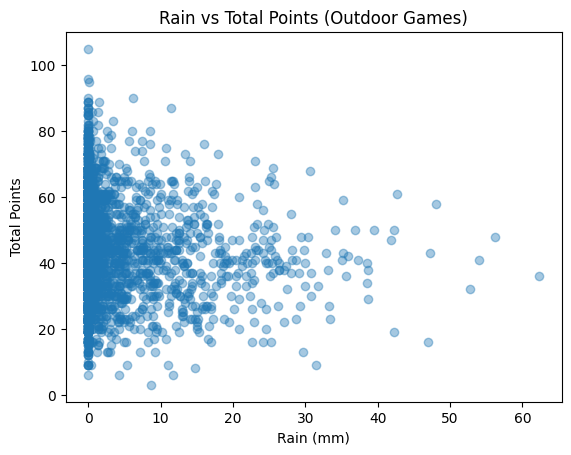

In [182]:
# It looks like theres a small difference, but here is a visual assessment

plt.figure()
plt.scatter(outdoor_df["rain_sum"], outdoor_df["total_points"], alpha=0.4)
plt.xlabel("Rain (mm)")
plt.ylabel("Total Points")
plt.title("Rain vs Total Points (Outdoor Games)")
plt.show()

In [164]:
# The difference is statistically significant

In [165]:
# Now we'll look at the impact of snow

outdoor_df.groupby("snow_any")["total_points"].describe()

,count,mean,std,min,25%,50%,75%,max
snow_any,,,,,,,,
False,3625.0,44.154483,13.716515,3.0,35.0,44.0,52.00,105.0
True,290.0,44.886207,15.426940,6.0,34.0,44.0,54.75,86.0


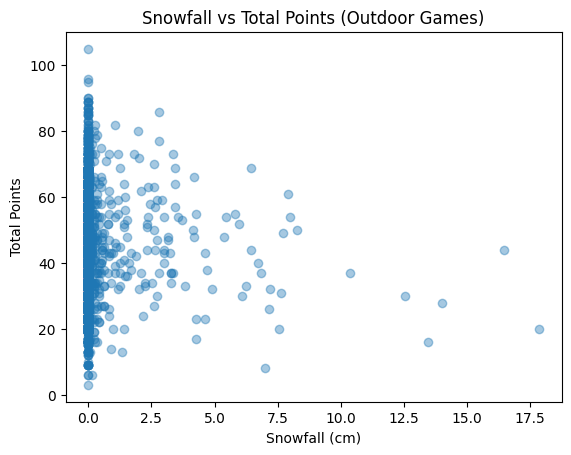

In [180]:
# There doesnt seem to be a big difference, but here it is visually

plt.figure()
plt.scatter(outdoor_df["snowfall_sum"], outdoor_df["total_points"], alpha=0.4)
plt.xlabel("Snowfall (cm)")
plt.ylabel("Total Points")
plt.title("Snowfall vs Total Points (Outdoor Games)")
plt.show()

In [167]:
# There does not seem to be a significant difference in snow games, but the sample 
# size is very small, only 290 games

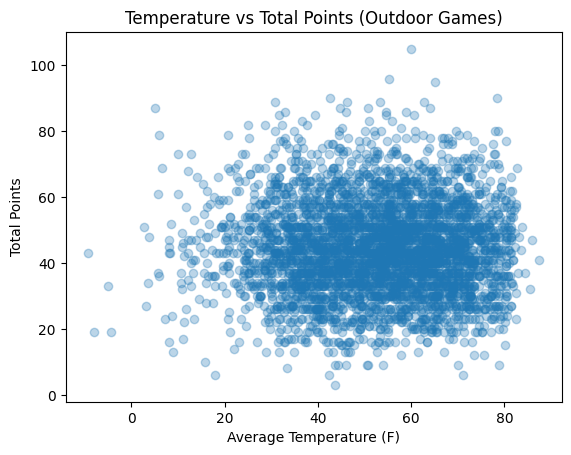

In [168]:
# Now we'll look at the impact of temperature

import matplotlib.pyplot as plt

plt.scatter(outdoor_df["avg_temp"], outdoor_df["total_points"], alpha=0.3)
plt.xlabel("Average Temperature (F)")
plt.ylabel("Total Points")
plt.title("Temperature vs Total Points (Outdoor Games)")
plt.show()

In [169]:
# It looks like the warmer weather results in less variability in points scored

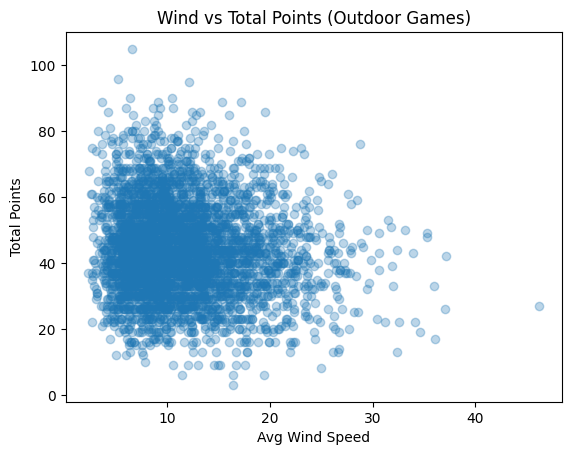

In [175]:
# Now we will look at wind

plt.scatter(outdoor_df["wind_speed_avg"], outdoor_df["total_points"], alpha=0.3)
plt.xlabel("Avg Wind Speed")
plt.ylabel("Total Points")
plt.title("Wind vs Total Points (Outdoor Games)")
plt.show()

In [190]:
# It looks like wind speed is negatively correlated with total points

In [191]:
# Now we will combine all the variables and assess which factors effect the total
# points scored the most

In [183]:
weather_corr = outdoor_df[
    ["total_points", "avg_temp", "rain_sum", "wind_speed_avg", "snowfall_sum"]
].corr()

In [184]:
weather_corr

,total_points,avg_temp,rain_sum,wind_speed_avg,snowfall_sum
total_points,1.000000,-0.001733,-0.080649,-0.113236,-0.022284
avg_temp,-0.001733,1.000000,0.092006,-0.134606,-0.227843
rain_sum,-0.080649,0.092006,1.000000,0.235855,-0.001417
wind_speed_avg,-0.113236,-0.134606,0.235855,1.000000,0.116552
snowfall_sum,-0.022284,-0.227843,-0.001417,0.116552,1.000000


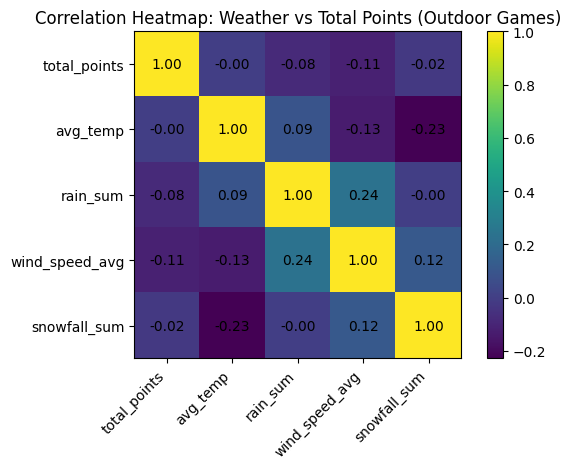

In [187]:
plt.figure()
im = plt.imshow(weather_corr)
plt.colorbar(im)

plt.xticks(
    ticks=np.arange(len(weather_corr.columns)),
    labels=weather_corr.columns,
    rotation=45,
    ha="right"
)
plt.yticks(
    ticks=np.arange(len(weather_corr.index)),
    labels=weather_corr.index
)

for i in range(len(weather_corr.index)):
    for j in range(len(weather_corr.columns)):
        plt.text(
            j, i,
            f"{weather_corr.iloc[i, j]:.2f}",
            ha="center", va="center"
        )

plt.title("Correlation Heatmap: Weather vs Total Points (Outdoor Games)")
plt.tight_layout()
plt.show()

In [188]:
# The correlation heatmap shows that weather variables have small but consistently
# negative relationships with total points scored in outdoor NFL games

In [192]:
# Of the variables above, wind speed exhibits the strongest negative correlation with
# total points (−0.11), followed by rainfall (−0.08)

In [193]:
# And just for fun, we will predict how many points will be scored during the 
# superbowl based on it being an outside venue and expected weather conditions

In [202]:
# To do this we will create an OLS model is fit on outdoor games using a numeric 
# design matrix with an intercept, estimated via least squares to avoid numerical
# instability from matrix inversion

In [203]:
# Force numeric types (bool -> 0/1, objects -> floats)
X = outdoor_df[["avg_temp", "rain_any", "snow_any", "wind_speed_avg"]].astype(float).to_numpy()
y = outdoor_df["total_points"].astype(float).to_numpy()

# Add intercept
X = np.column_stack([np.ones(len(X)), X])

In [204]:
# OLS coefficients (more stable than inv)
beta = np.linalg.lstsq(X, y, rcond=None)[0]
beta

array([ 4.76756334e+01,  6.86685241e-04, -5.00386854e-01,  1.86898881e+00,
       -2.98649366e-01])

In [205]:
sb_weather = np.array([1, 48, 0, 0, 12], dtype=float)
pred_points = sb_weather @ beta
pred_points

np.float64(44.12480192754945)

In [206]:
# Based on our model, we predict that the total number of points that will be scored
# during the superbowl is 44